# Create Hazard Tables
This notebook creates hazard tables to use in cox regression. It creates one hazard table per block (so there is a matching data json file). 

In [1]:
%pylab inline
from helpers import retrace
import json
import copy
import pandas as pd
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


In [14]:
block_file = '../results-anonymized/pilot/pilot_20200505-7_block_1.json'
hazard_table_file = '../results-anonymized/pilot/pilot_20200505-7_block_1_hazard_table.csv'

In [15]:
def fast_n_triangle_paths(M, edge):
    """ Fast check for triangle closing rule"""
    try:
        from_neighbors = set(M[edge[0]])  # if concept 0 not in network, false
        to_neighbors = set(M[edge[1]])  # if concept 1 not in network, false
        return len(from_neighbors & to_neighbors)  # closes number of existing paths
    except:
        return 0


def instantaneous_hazard_factors(
    game, g, t,
    startup_period=30,
):
    """
    Given the state of the game, what are the factors influencing the hazard of adopting all beliefs?

    Returns a row for the hazard factors of all individuals for adopting all beliefs 
    given the current state of the game. Gets big fast.
    """
    prompt_nodes = set(game['data.clues']['tclue_1_2']['nodes'])

    rows = []
    for player_id, player_data in game['players'].items():

        pos = player_data['data.position']
        M = g.nodes()[player_id]['M']  # promising leads (memory)
        F = g.nodes()[player_id]['F']  # dead ends (forgetory)

        for clue_id, clue_data in game['data.clues'].items():
            if clue_id[0] == pos[0]: # only collect treatment clues for treatment players & vice versa
                
                nodes = set(clue_data['nodes'])
                row = {
                    'start': t,
                    
                    'exposure_id': '%s_%s'%(player_id, clue_id),  # to group all rows corresponding to same exposure 
                    'player_id': player_id,  # player random effect
                    'game_id': game['_id'],  # game random effect
                    'is_caveman_game': 'caveman' in game['data.gameSetupId'],
    
                    'is_treatment_condition': pos.startswith('t'),
                    'is_spoke': len(nodes.intersection(prompt_nodes)) == 1,
                    'is_link_or_spur': len(nodes.intersection(prompt_nodes)) == 0,
                    'is_prompt': nodes == prompt_nodes,
                    'is_in_leads': M.has_edge(*nodes),
                    'is_in_deads': F.has_edge(*nodes),
                    
                    'n_exposures': sum([g.nodes()[nid]['M'].has_edge(*nodes) for nid in g.neighbors(player_id)]),  # number of neighbors exposing

                    # number of beliefs already adopted
                    'n_existing_leads': M.number_of_edges(),
                    
#                    'n_fresh_candidates': ... # expensive, and not very influential 
                    'in_startup_period': t<=startup_period,
                    
                    # number of connections by any clue to any of the rim nodes
                    'n_rim_connections': sum([v for k,v in M.degree(nodes-prompt_nodes)]),  # includes the current clue, if it exists
                    
                    # number of triangle paths
                    'n_triangle_paths': fast_n_triangle_paths(M, clue_data['nodes']),
                    
                    # number of beliefs that the player has that are also in the exposers' leads
                    'n_edges_shared_with_exposers': len({
                        edge for nid in g.neighbors(player_id) 
                        if g.nodes()[nid]['M'].has_edge(*nodes) 
                        for edge in g.nodes()[nid]['M'].edges()
                    }.intersection({edge for edge in M.edges()})), 
#                    'n_spoke_connections': ... # todo. 
#                    'n_link_or_spur_connections': 
                }
                row['is_link'] = row['is_link_or_spur'] & row['is_treatment_condition']
                row['is_spur'] = row['is_link_or_spur'] & ~row['is_treatment_condition']                
                rows.append(row)

    return rows



In [16]:
with open(block_file, 'r') as f:
    batch = json.load(f)

hazard_factors_list = []
for batch_name, game in batch.items():
    for (active_player_id, g, t) in retrace(game):
        hazard_factors_list += instantaneous_hazard_factors(game, g, t)


hazard_factors = pd.DataFrame(hazard_factors_list)

In [17]:
def process_exposure_group(group, t_last):
    """
    Groups represent player-clue combinations, or unique "exposure" possibilities
    Takes the hazard table and creates a table that lifelines can use.
    1. Condenses multiple rows (by dropping duplicates)
    2. Treats start and end times
    3. Identifies adoption events
    """
    
    # discard player-clue groups where the player is never exposed to the clue
    if max(group['n_exposures']) == 0: 
        return pd.DataFrame()
    
    # check that group is sorted
    group.sort_values(['start'], inplace=True)
    
    # drop consecutive duplicate rows (ie, nothing changes w.r.t. the adoption factors)
    match_on_cols = set(group.columns) - {'start'}
    keep_rows = (group[match_on_cols].shift() != group[match_on_cols]).any(axis=1)
    group = group.loc[keep_rows]

    # identify exposures where the player is exposed at start
    # the player may react differently to these than others
    group['is_exposed_t0'] = (group[group['start']<3]['n_exposures'] > 0).any()
    
    # identify clues the player holds at start
    group['is_held_t0'] = (group[group['start']<3]['is_in_leads']).any()

    # add "stop" column
    group['stop'] = group['start'].shift(-1)
    group.loc[group.index[-1], 'stop'] = t_last
    
    # identify "adopt" events 
    # ie. the row period ends with an adoption change
    group['adopt_event'] = group['is_in_leads'] < group.shift(-1)['is_in_leads']
    group.loc[group.index[-1], 'adopt_event'] = False

    # identify "forget" events
    group['forget_event'] = group['is_in_leads'] > group.shift(-1)['is_in_leads']
    group.loc[group.index[-1], 'forget_event'] = False

    return group
    

t_final = datetime.strptime(game['finishedAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
total_time = (t_final-t_start).total_seconds()

res_list = []
for i, (eid, group) in enumerate(hazard_factors.groupby('exposure_id')):
    res_list.append(process_exposure_group(group, total_time))

hazard_table = pd.concat(res_list)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [18]:
(hazard_table*1).to_csv(hazard_table_file)

In [19]:
!say "analysis complete"

In [26]:
(hazard_table[hazard_table['adopt_event'] 
              & hazard_table['is_spoke']
              & hazard_table['is_treatment_condition']
             ]['n_rim_connections'] > 0).value_counts()

True     217
False     55
Name: n_rim_connections, dtype: int64

In [27]:
(hazard_table[hazard_table['adopt_event'] 
              & hazard_table['is_spoke']
              & ~hazard_table['is_treatment_condition']
             ]['n_rim_connections'] > 0).value_counts()

True     171
False    120
Name: n_rim_connections, dtype: int64

In [11]:
hazard_table[hazard_table['forget_event']==1]['is_in_leads'].value_counts()

True    257
Name: is_in_leads, dtype: int64

227.4079236234459

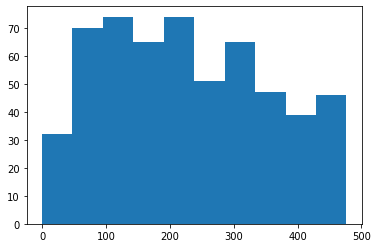

In [28]:
plt.hist(hazard_table[hazard_table['adopt_event'] & hazard_table['is_spoke']]['start']);
hazard_table[hazard_table['adopt_event'] & hazard_table['is_spoke']]['start'].mean()

221.94218584070805

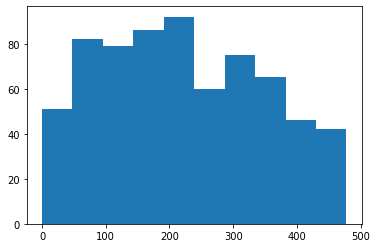

In [29]:
plt.hist(hazard_table[hazard_table['adopt_event'] & hazard_table['is_link_or_spur']]['start']);
hazard_table[hazard_table['adopt_event'] & hazard_table['is_link_or_spur']]['start'].mean()

In [108]:
(hazard_table[hazard_table['adopt_event'] & hazard_table['is_spoke']]['rim_connections'] > 0).value_counts()

True     251
False    108
Name: rim_connections, dtype: int64

In [99]:
(hazard_table[hazard_table['adopt_event'] & hazard_table['is_link_or_spur']]['rim_connections'] > 0).value_counts()

True     317
False     45
Name: rim_connections, dtype: int64

In [23]:
player_data

{'_id': '6xqcSF4HGmibhb96j',
 'readyAt': '2020-05-05T18:02:13.542Z',
 'exitStepsDone': ['MakeTheCase', 'ExitSurvey'],
 'exitAt': '2020-05-05T18:18:49.441Z',
 'exitStatus': 'finished',
 'createdAt': '2020-05-05T18:00:42.466Z',
 'data.index': 5,
 'data.position': 't5',
 'data.alterIDs': ['QC99S28ruEE8MLdhK',
  '8mWhGzqY826Tee4oh',
  'SWm3TDdgkkmEJihyu'],
 'data.log': [{'event': 'idle', 'data': {}, 'at': '2020-05-05T18:17:46.610Z'}],
 'data.activity': 'active',
 'data.notebookOrder': ['promising_leads', 'dead_ends'],
 'data.notebooks': {'promising_leads': {'id': 'promising_leads',
   'title': 'Promising Leads',
   'clueIDs': ['tclue_1_2',
    'tclue_2_10',
    'tclue_1_10',
    'tclue_2_5',
    'tclue_1_6',
    'tclue_2_13',
    'tclue_2_6']},
  'dead_ends': {'id': 'dead_ends',
   'title': 'Dead Ends',
   'clueIDs': ['tclue_12_13',
    'tclue_3_6',
    'tclue_3_10',
    'tclue_1_3',
    'tclue_5_13',
    'tclue_3_5',
    'tclue_4_5',
    'tclue_5_8']}},
 'data.initialState': {'promising_l

In [25]:
M.edges()

EdgeView([('Mills', 'a silver VW Jetta'), ('Mills', 'Cooper'), ('a silver VW Jetta', 'a blue Toyota Yaris'), ('a blue long sleeve shirt', 'the bracelet')])

In [16]:
game['_id']

'xXvsHQvoQC4LsoyCi'